<a href="https://colab.research.google.com/github/Anshul-Sangrame/DL-assgn3/blob/main/CS21BTECH11004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI5100 Assignment 3

**Name**: Anshul Sangrame

**Roll Number**: CS21BTECH11004

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

# Selecting Device



In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Data loader

In [ ]:
train_data = datasets.CIFAR10('/data',download=True,transform=ToTensor())

train_data.__len__()

100%|██████████| 170498071/170498071 [00:05<00:00, 29178561.87it/s]


Extracting /data/cifar-10-python.tar.gz to /data


50000

In [ ]:
test_data = datasets.CIFAR10('/data',train=False,download=True,transform=ToTensor())

test_data.__len__()

Files already downloaded and verified


10000

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([100, 3, 32, 32])
Shape of y: torch.Size([100]) torch.int64


# Model trainer

In [ ]:
def train_one_epoch(model,dataloader,loss_fn,optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0,0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == (100-1):
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss,correct

def test_one_epoch(model,dataloader,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss,correct

def train_model(model,train_dataloader,test_dataloader,epoch,lr=1e-3):
  train_loss_hist = []
  train_acc_hist = []
  test_loss_hist = []
  test_acc_hist = []

  loss_fn = nn.CrossEntropyLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr)
  optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, nesterov=True)

  for i in range(int(epoch)):
    print(f"Epoch {i+1}\n-------------------------------")
    train_loss, train_acc = train_one_epoch(model,train_dataloader,loss_fn,optimizer)
    test_loss, test_acc = test_one_epoch(model,test_dataloader,loss_fn)

    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)

  x = range(1,epoch+1)
  # Plot loss curve
  fig, axs = plt.subplots(2)
  axs[0].plot(x, train_loss_hist,label="Training")
  axs[0].plot(x, test_loss_hist,label="Validation")
  axs[0].grid()
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  # Plot accuracy curve
  axs[1].plot(x, train_acc_hist,label="Training")
  axs[1].plot(x, test_acc_hist,label="Validation")
  axs[1].grid()
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  fig.suptitle('Learning Curves')
  fig.tight_layout()
  fig.show()

  return train_loss_hist,test_loss_hist,train_acc_hist,test_acc_hist

# Function to find number of parameters

In [ ]:
def num_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Part-1

## Self-attention 2D module

In [ ]:
class SA_2D(nn.Module):
  def __init__(self,in_channels,qkv_channels):
    super().__init__()
    self.in_channels = in_channels
    self.qkv_channels = qkv_channels

    self.query = self._conv()
    self.key = self._conv()
    self.value = self._conv()

    self.softmax = nn.Softmax(dim=-1)

    self.last_conv = self._conv_last()

  def _conv(self):
    return nn.Conv2d(self.in_channels, self.qkv_channels, 1)
  def _conv_last(self):
    return nn.Conv2d(self.qkv_channels, self.in_channels, 1)

  def forward(self,x):
    Q = self.query(x).flatten(start_dim = 2)
    K = self.key(x).flatten(start_dim = 2)
    V = self.value(x).flatten(start_dim = 2)

    E = torch.bmm(Q.transpose(1,2), K)
    A = self.softmax(E)

    y = torch.bmm(V, A)
    y = y.reshape((x.shape[0],self.qkv_channels,*x.shape[2:]))

    y = self.last_conv(y)

    return x + y


## CNN Network

In [ ]:
class net_SA(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), # out_size = (N,16,32,32)
            nn.ReLU(inplace=True), # out_size = (N,16,32,32)
            nn.BatchNorm2d(16), # out_size = (N,16,32,32)
            nn.Conv2d(16, 32, 3, padding=1), # out_size = (N,32,32,32)
            nn.ReLU(inplace=True), # out_size = (N,32,32,32)
            nn.BatchNorm2d(32), # out_size = (N,32,32,32)
            SA_2D(in_channels=32, qkv_channels=16), # out_size = (N,32,32,32)
            nn.Conv2d(32, 64, 3, padding=1), # out_size = (N,64,32,32)
            nn.ReLU(inplace=True), # out_size = (N,64,32,32)
            nn.BatchNorm2d(64), # out_size = (N,64,32,32)
            SA_2D(in_channels=64, qkv_channels=32), # out_size = (N,64,32,32)
            nn.MaxPool2d(2), # out_size = (N,64,16,16)
            nn.Conv2d(64, 128, 3, padding=1), # out_size = (N,128,16,16)
            nn.ReLU(inplace=True), # out_size = (N,128,16,16)
            nn.BatchNorm2d(128), # out_size = (N,128,16,16)
            SA_2D(in_channels=128, qkv_channels=64), # out_size = (N,128,16,16)
            nn.MaxPool2d(2), # out_size = (N,128,8,8)
            nn.Conv2d(128, 256, 3, padding=1), # out_size = (N,256,8,8)
            nn.ReLU(inplace=True),  # out_size = (N,256,8,8)
            nn.BatchNorm2d(256),  # out_size = (N,256,8,8)
            # SA_2D(in_channels=256, qkv_channels=128),  # out_size = (N,256,8,8)
            nn.AdaptiveAvgPool2d(1),  # out_size = (N,256,1,1)
            nn.Flatten(), # out_size: (N,256)
            nn.Dropout(), # out_size: (N,256)
            nn.Linear(256, 32), # out_size: (N,32)
            nn.ReLU(inplace=True), # out_size: (N,32)
            nn.Dropout(), # out_size: (N,32)
            nn.Linear(32, 10), # out_size: (N,10)
        )

    def forward(self, x):
        return self.cnn(x)

## Training

In [ ]:
model = net_SA().to(device)
print(model)

net_SA(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SA_2D(
      (query): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
      (last_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SA_2D(
      (query): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1

In [ ]:
print(f"Number of parameters: {num_parameters(model)}")

Number of parameters: 445722


Epoch 1
-------------------------------
loss: 2.268199  [10000/50000]
loss: 2.199353  [20000/50000]
loss: 2.060759  [30000/50000]
loss: 2.106733  [40000/50000]
loss: 1.958734  [50000/50000]
Train Error: 
 Accuracy: 19.8%, Avg loss: 2.144287 

Test Error: 
 Accuracy: 27.2%, Avg loss: 1.983403 

Epoch 2
-------------------------------
loss: 1.870894  [10000/50000]
loss: 1.925784  [20000/50000]
loss: 1.798681  [30000/50000]
loss: 1.877703  [40000/50000]
loss: 1.729749  [50000/50000]
Train Error: 
 Accuracy: 32.6%, Avg loss: 1.798370 

Test Error: 
 Accuracy: 42.7%, Avg loss: 1.575529 

Epoch 3
-------------------------------
loss: 1.640395  [10000/50000]
loss: 1.680706  [20000/50000]
loss: 1.607858  [30000/50000]
loss: 1.405533  [40000/50000]
loss: 1.665266  [50000/50000]
Train Error: 
 Accuracy: 40.2%, Avg loss: 1.615331 

Test Error: 
 Accuracy: 47.0%, Avg loss: 1.466141 

Epoch 4
-------------------------------
loss: 1.539203  [10000/50000]
loss: 1.386511  [20000/50000]
loss: 1.450056 

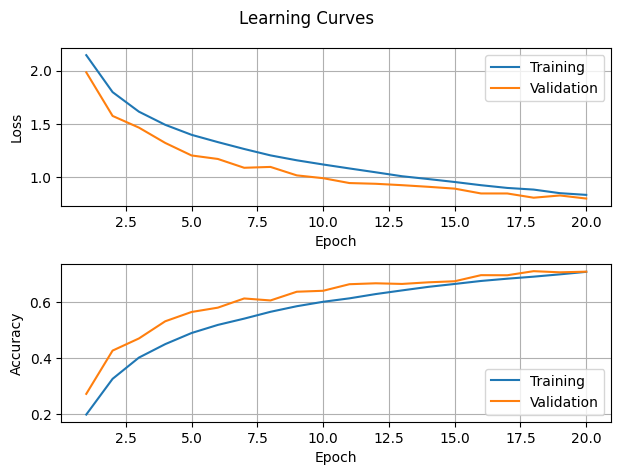

In [ ]:
EPOCH = 20
cnn_train_loss_hist,cnn_test_loss_hist,cnn_train_acc_hist,cnn_test_acc_hist = train_model(model,train_dataloader,test_dataloader,EPOCH)

# Part-2

## Embedding

In [ ]:
class embedding(nn.Module):
  def __init__(self,image_size,patch_size,emb_size):
    super().__init__()
    self.image_size = image_size
    self.patch_size = patch_size
    self.emb_size = emb_size

    C,H,W = self.image_size
    assert H % self.patch_size == 0, "Invalid patch size"
    assert W % self.patch_size == 0, "Invalid patch size"

    patch_flatten_size = patch_size*patch_size*C
    n_patches = int((H*W)/(patch_size**2))

    self.linear_transform = nn.Linear(patch_flatten_size,self.emb_size)
    self.class_tok = nn.Parameter(torch.randn(1,1,self.emb_size))
    self.pos_emb = nn.Parameter(torch.randn((n_patches + 1, self.emb_size)))

  def image_to_patches(self,image):
    # image: input image tensor of shape (N,C, H, W)
    # patch_size: size of each patch (P, P)
    N,C,H,W = image.shape

    assert image.shape[1:] == self.image_size, "Invalid image shape"

    # Unfold the image tensor to extract patches
    patches = image.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)

    # Reshape the patches tensor to have a proper shape
    patches = patches.contiguous().view(N,-1, C, self.patch_size, self.patch_size)

    patches = patches.flatten(2)

    return patches

  def forward(self,x):
    x = self.image_to_patches(x)
    x = self.linear_transform(x)
    class_tok = self.class_tok.repeat((x.shape[0],1,1))
    x = torch.cat((class_tok, x), 1)
    x = x + self.pos_emb
    return x


## Self-attention 1D module

In [ ]:
class SA_1D(nn.Module):
  def __init__(self,emb_size,qk_size,v_size):
    super().__init__()

    self.emb_size = emb_size
    self.qk_size = qk_size
    self.v_size = v_size

    self.query = nn.Linear(self.emb_size, self.qk_size)
    self.key = nn.Linear(self.emb_size, self.qk_size)
    self.value = nn.Linear(self.emb_size, self.v_size)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self,x):
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    E = torch.bmm(Q, K.transpose(-2, -1))
    A = self.softmax(E/np.sqrt(self.qk_size))
    y = torch.bmm(A, V)
    return y

## Multi-headed self-attention

In [ ]:
class multi_SA(nn.Module):
  def __init__(self,emb_size,qk_size,v_size,n_heads):
    super().__init__()

    self.sa_list = nn.ModuleList([
        SA_1D(emb_size,qk_size,v_size) for _ in range(n_heads)
    ])

    self.linear = nn.Linear(n_heads*v_size,emb_size)

  def forward(self,x):
    return self.linear(torch.cat([sa(x) for sa in self.sa_list], dim=-1))

## Encoder block

In [ ]:
class block(nn.Module):
  def __init__(self,emb_size,qk_size,v_size,n_heads,intermediate_size):
    super().__init__()

    self.msa = nn.Sequential(
      nn.LayerNorm(emb_size),
      multi_SA(emb_size,qk_size,v_size,n_heads),
    )
    self.mlp = nn.Sequential(
      nn.LayerNorm(emb_size),
      nn.Dropout(),
      nn.Linear(emb_size, intermediate_size),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(intermediate_size, emb_size),
      nn.ReLU(inplace=True),
    )

  def forward(self,x):
    x = x + self.msa(x)
    return x + self.mlp(x)

## ViT

In [ ]:
class ViT(nn.Module):
  def __init__(self,image_size,patch_size,qk_size,v_size,emb_size,n_blocks,n_heads,intermediate_size):
    super().__init__()

    self.embed = embedding(image_size,patch_size,emb_size)
    self.blocks = nn.Sequential( *([
        block(emb_size,qk_size,v_size,n_heads,intermediate_size) for _ in range(n_blocks)
    ]))

    self.mlp_head = nn.Linear(emb_size, 10)

  def forward(self,x):
    x = self.embed(x)
    x = self.blocks(x)
    x_class = x[:,0,:]
    return self.mlp_head(x_class)


## Training ViT

In [ ]:
model = ViT((3,32,32),4,64,32,32,8,8,64).to(device)
print(model)

ViT(
  (embed): embedding(
    (linear_transform): Linear(in_features=48, out_features=32, bias=True)
  )
  (blocks): Sequential(
    (0): block(
      (msa): Sequential(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (1): multi_SA(
          (sa_list): ModuleList(
            (0-7): 8 x SA_1D(
              (query): Linear(in_features=32, out_features=64, bias=True)
              (key): Linear(in_features=32, out_features=64, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (softmax): Softmax(dim=-1)
            )
          )
          (linear): Linear(in_features=256, out_features=32, bias=True)
        )
      )
      (mlp): Sequential(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(in_features=32, out_features=64, bias=True)
        (3): ReLU(inplace=True)
        (4): Dropout(p=0.5, inplace=False)
        (5): Linear(in_feat

In [ ]:
print(f"Number of parameters: {num_parameters(model)}")

Number of parameters: 442282


Epoch 1
-------------------------------
loss: 2.394297  [10000/50000]
loss: 2.287244  [20000/50000]
loss: 2.296917  [30000/50000]
loss: 2.311956  [40000/50000]
loss: 2.288807  [50000/50000]
Train Error: 
 Accuracy: 11.1%, Avg loss: 2.339384 

Test Error: 
 Accuracy: 12.8%, Avg loss: 2.326055 

Epoch 2
-------------------------------
loss: 2.248872  [10000/50000]
loss: 2.290516  [20000/50000]
loss: 2.305082  [30000/50000]
loss: 2.276370  [40000/50000]
loss: 2.286070  [50000/50000]
Train Error: 
 Accuracy: 13.8%, Avg loss: 2.284983 

Test Error: 
 Accuracy: 13.0%, Avg loss: 2.322288 

Epoch 3
-------------------------------
loss: 2.326661  [10000/50000]
loss: 2.231103  [20000/50000]
loss: 2.272365  [30000/50000]
loss: 2.310571  [40000/50000]
loss: 2.277644  [50000/50000]
Train Error: 
 Accuracy: 14.5%, Avg loss: 2.270459 

Test Error: 
 Accuracy: 13.8%, Avg loss: 2.298840 

Epoch 4
-------------------------------
loss: 2.273503  [10000/50000]
loss: 2.270272  [20000/50000]
loss: 2.291287 

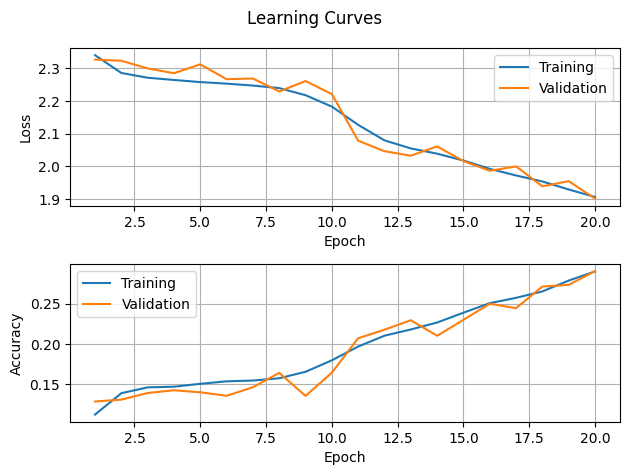

In [ ]:
EPOCH = 20
ViT_train_loss_hist,ViT_test_loss_hist,ViT_train_acc_hist,ViT_test_acc_hist = train_model(model,train_dataloader,test_dataloader,EPOCH)

## Comparison

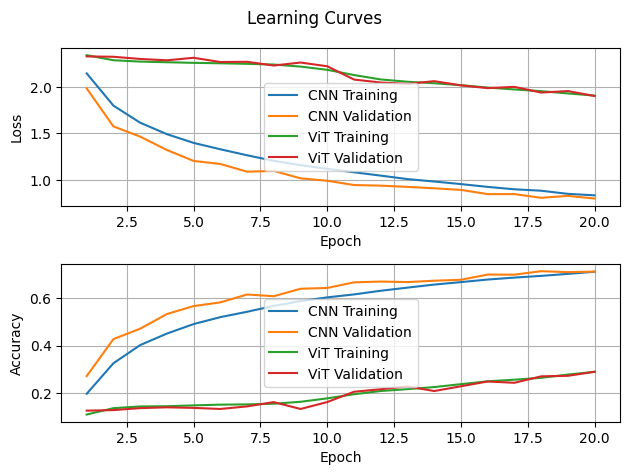

In [ ]:
# Plot loss curve
x = range(1,EPOCH+1)
fig, axs = plt.subplots(2)
axs[0].plot(x, cnn_train_loss_hist,label="CNN Training")
axs[0].plot(x, cnn_test_loss_hist,label="CNN Validation")
axs[0].plot(x, ViT_train_loss_hist,label="ViT Training")
axs[0].plot(x, ViT_test_loss_hist,label="ViT Validation")
axs[0].grid()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot accuracy curve
axs[1].plot(x, cnn_train_acc_hist,label="CNN Training")
axs[1].plot(x, cnn_test_acc_hist,label="CNN Validation")
axs[1].plot(x, ViT_train_acc_hist,label="ViT Training")
axs[1].plot(x, ViT_test_acc_hist,label="ViT Validation")
axs[1].grid()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

fig.suptitle('Learning Curves')
fig.tight_layout()
fig.show()

## Observation:
- CNN reached an accuracy of 71% in 20 epoch whereas ViT reached an accuracy of 30% in 20 epoch.ViT does not work well with small ammount of data because of LayerNorm layer.
- ViT took 14 mins for 20 epoch whereas CNN took 18 mins for 20 epoch. ViT is faster than CNN.